# Análisis series de tiempo usando MLP

**Autor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />
**Github:** <https://github.com/rpmunoz> <br />

Basado en el análisis de Jason Brownlee https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/

Usaremos un dataset de ventas mensuales de champú entre 1901 y 1903. El dataset contiene 36 observaciones y puede ser descargado desde https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv


## Instalamos keras y tensorflow

In [ ]:
!pip install keras tensorflow

## Cargamos las librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from math import sqrt

Using TensorFlow backend.


In [2]:
# load dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

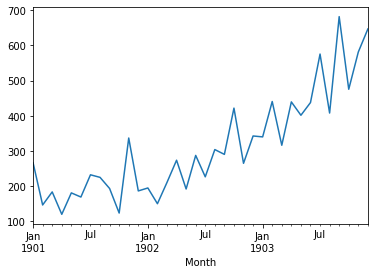

In [3]:
series.plot()

## Data Split

Dividiremos el conjunto de datos de Shampoo Sales en dos partes: uno de entrenamiento y otro de evaluación.

Se tomarán los primeros dos años de datos para el conjunto de datos de entrenamiento y el año restante de datos se usará para el conjunto de pruebas.

Los modelos se desarrollarán utilizando el conjunto de datos de entrenamiento y harán predicciones sobre el conjunto de datos de prueba.

El pronóstico de persistencia (pronóstico ingenuo) en el conjunto de datos de prueba logra un error de 136.761 ventas mensuales de champú. Esto proporciona un límite de rendimiento aceptable más bajo en el conjunto de prueba.

In [4]:
train, test = series[0:-12], series[-12:]

print("\nTrain")
print(train)

print("\nTest")
print(test)


Train
Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
Name: Sales, dtype: float64

Test
Month
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales, dtype: float64


## Evaluación del modelo

Se utilizará un escenario de pronóstico continuo, también denominado validación del modelo de avance.

Cada paso del conjunto de datos de prueba se caminará uno a la vez. Se utilizará un modelo para hacer un pronóstico para el paso de tiempo, luego se tomará el valor esperado real del conjunto de prueba y se pondrá a disposición del modelo para el pronóstico en el próximo paso de tiempo.

Esto imita un escenario del mundo real donde las nuevas observaciones de Shampoo Sales estarían disponibles cada mes y se usarían en el pronóstico del mes siguiente.

Esto será simulado por la estructura del entrenamiento y los conjuntos de datos de prueba.

Se recopilarán todos los pronósticos en el conjunto de datos de prueba y se calculará una puntuación de error para resumir la habilidad del modelo. Se utilizará el error cuadrático medio (RMSE), ya que castiga los errores grandes y da como resultado una puntuación que se encuentra en las mismas unidades que los datos de pronóstico, es decir, las ventas mensuales de champú.

## Preparación de los datos

Antes de que podamos ajustar un modelo MLP al conjunto de datos, debemos transformar los datos.

Las siguientes tres transformaciones de datos se realizan en el conjunto de datos antes de ajustar un modelo y hacer un pronóstico.

1. Transforme los datos de la serie temporal para que sean estacionarios. Específicamente, una diferencia de retraso = 1 para eliminar la tendencia creciente en los datos.

2. Transforme la serie temporal en un problema de aprendizaje supervisado. Específicamente, la organización de datos en patrones de entrada y salida donde la observación en el paso de tiempo anterior se usa como entrada para pronosticar la observación en el paso de tiempo actual

3. Transforme las observaciones para tener una escala específica. Específicamente, para reescalar los datos a valores entre -1 y 1.

Estas transformaciones se invierten en pronósticos para devolverlos a su escala original antes del cálculo y la puntuación de error.

In [5]:
# date-time parsing function for loading the dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

## Modelo MLP

Utilizaremos un modelo MLP base con una capa oculta, una función de activación lineal rectificada en neuronas ocultas y una función de activación lineal en neuronas de salida.

Cuando sea posible, se usa un tamaño de lote de 4, con los datos de entrenamiento truncados para garantizar que el número de patrones sea divisible entre 4. En algunos casos se usa un tamaño de lote de 2.

Normalmente, el conjunto de datos de entrenamiento se baraja después de cada lote o cada época, lo que puede ayudar a ajustar el conjunto de datos de entrenamiento en problemas de clasificación y regresión. La combinación aleatoria se desactivó para todos los experimentos, ya que parecía tener un mejor rendimiento. Se necesitan más estudios para confirmar este resultado para el pronóstico de series de tiempo.

El modelo se ajustará utilizando el eficiente algoritmo de optimización ADAM y la función de pérdida de error cuadrática media.

In [7]:
# fit an MLP network to training data
def fit_model(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    
    model = Sequential() 
    model.add( Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add( Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model, history


## Creamos función para correr experimentos

Definimos la función experiment() para hacer N experimentos

In [8]:
# run a repeated experiment
def experiment(repeats, series, epochs, lag, neurons):
    
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, lag)
    supervised_values = supervised.values[lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    
    for r in range(repeats):
        # fit the model
        batch_size = 4
        train_trimmed = train_scaled[2:, :]
        
        model, history = fit_model(train_trimmed, batch_size, epochs, neurons)
                
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        output = model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
        
        plt.plot(history.history['loss'])
        plt.title('Evolución de la función de costo')
        plt.ylabel('loss')
        plt.xlabel('época')
        plt.show()


    return error_scores

## Corremos los experimentos

Definimos experimentos con numero de épocas igual a 50 y 100. Para cada valor de época hacemos 5 experimientos

W0809 13:22:47.852660 140736179954560 deprecation_wrapper.py:119] From /Users/rmunoz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 13:22:47.904159 140736179954560 deprecation_wrapper.py:119] From /Users/rmunoz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 13:22:47.925359 140736179954560 deprecation_wrapper.py:119] From /Users/rmunoz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 13:22:48.028074 140736179954560 deprecation_wrapper.py:119] From /Users/rmunoz/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.




Fitting model with 50 epochs


W0809 13:22:48.217792 140736179954560 deprecation_wrapper.py:119] From /Users/rmunoz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0809 13:22:48.392421 140736179954560 deprecation_wrapper.py:119] From /Users/rmunoz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



1) Test RMSE: 102.731


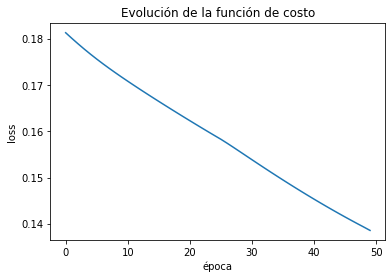

2) Test RMSE: 176.530


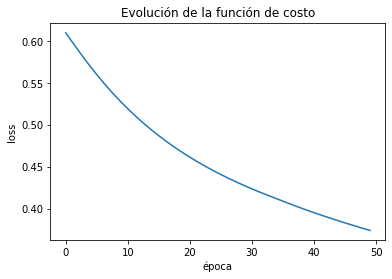

3) Test RMSE: 149.515


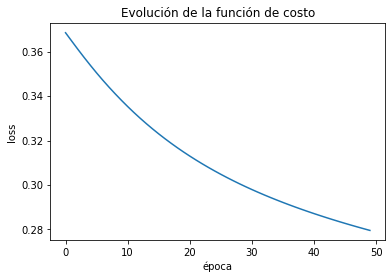

4) Test RMSE: 143.308


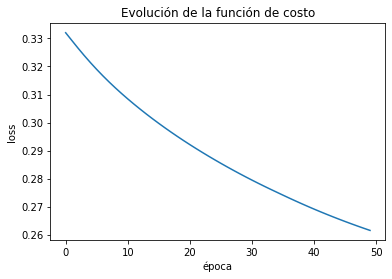

5) Test RMSE: 122.145


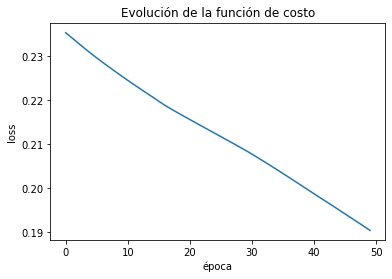


Fitting model with 100 epochs
1) Test RMSE: 135.341


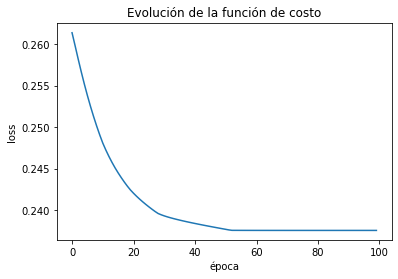

2) Test RMSE: 106.563


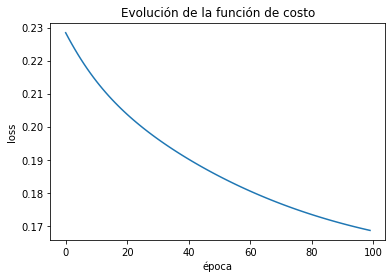

3) Test RMSE: 137.427


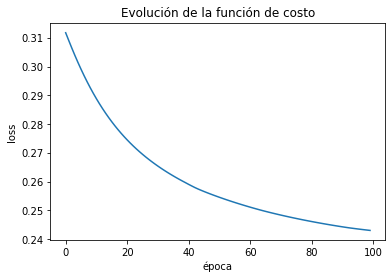

4) Test RMSE: 135.177


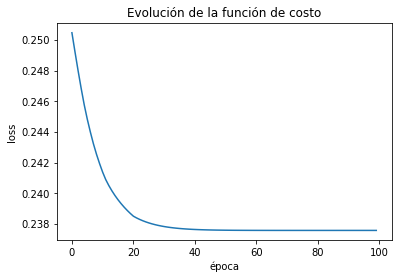

5) Test RMSE: 94.063


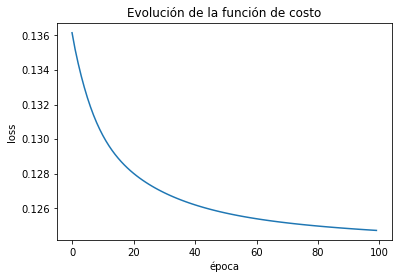

               50         100
count    5.000000    5.000000
mean   138.845612  121.714225
std     28.004554   20.049687
min    102.731073   94.063327
25%    122.144888  106.562888
50%    143.307580  135.176728
75%    149.514551  135.341084
max    176.529969  137.427099


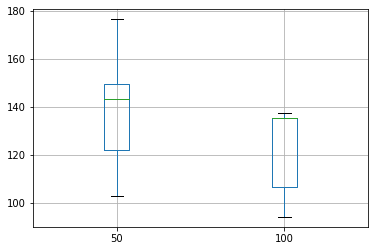

In [9]:
# experiment
repeats = 5
results = pd.DataFrame()
lag = 1
neurons = 1

# vary training epochs
epochs = [50, 100]
for e in epochs:
    print("\nFitting model with {} epochs".format(e))
    results[str(e)] = experiment(repeats, series, e, lag, neurons)
    
# summarize results
print(results.describe())
# save boxplot
results.boxplot()

## Evaluar modelo sobre test

Usamos el dataset de evaluación para ver el rendimiento del modelo

In [10]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # forecast dataset
    output = model.predict(X, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse

# fit an MLP network to training data
def fit(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    # prepare model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

# run diagnostic experiments
def run():
    # config
    repeats = 2
    n_batch = 4
    n_epochs = 100
    n_neurons = 1
    n_lag = 1
    
    # load dataset
    series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        plt.plot(history['train'], color='blue', label=('Train' if i==0 else None) )
        plt.plot(history['test'], color='orange', label=('Test' if i==0 else None) )
        plt.legend()
        plt.title('Evolución de la función de costo')
        plt.ylabel('RMSE')
        plt.xlabel('época')

        
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    plt.savefig('figures/diagnostic_epochs.png')


0) TrainRMSE=95.533521, TestRMSE=121.226063
1) TrainRMSE=70.085649, TestRMSE=107.421390


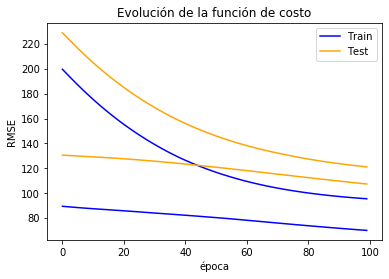

In [11]:
run()

## Experimentando con MLP


Fitting model using MLP with 1 neurons
1) Test RMSE: 138.831


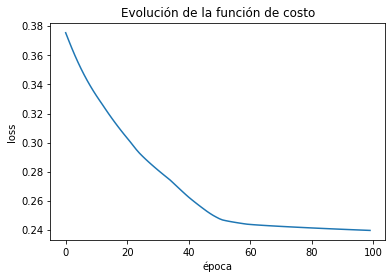

2) Test RMSE: 142.362


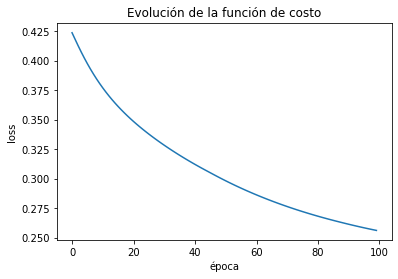

3) Test RMSE: 106.378


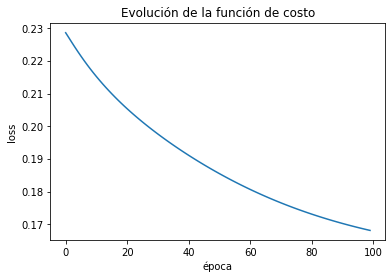

4) Test RMSE: 146.144


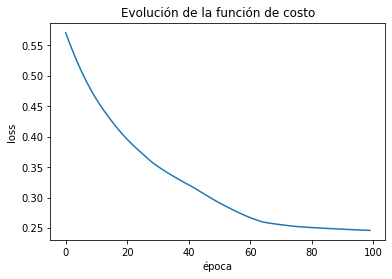

5) Test RMSE: 135.312


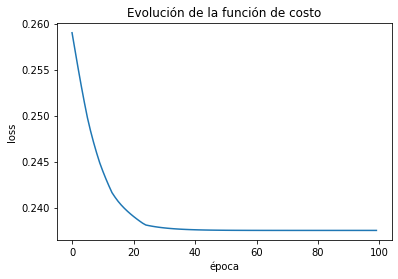


Fitting model using MLP with 2 neurons
1) Test RMSE: 143.614


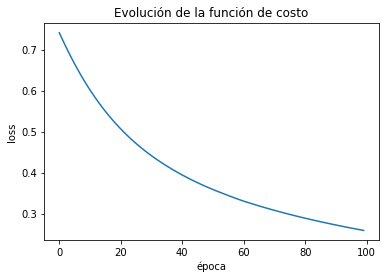

2) Test RMSE: 103.696


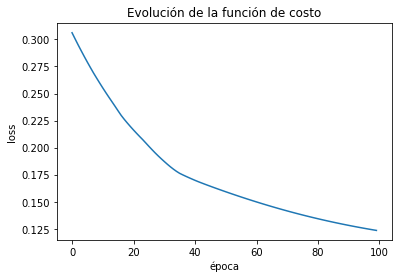

3) Test RMSE: 91.817


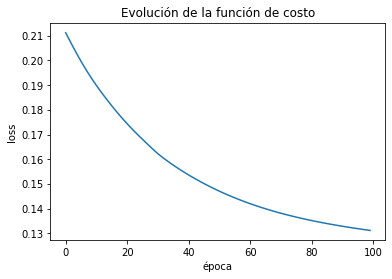

4) Test RMSE: 94.023


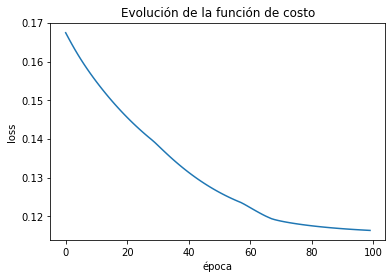

5) Test RMSE: 107.398


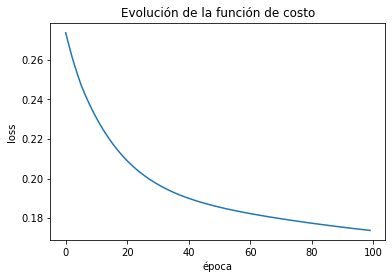


Fitting model using MLP with 3 neurons
1) Test RMSE: 106.431


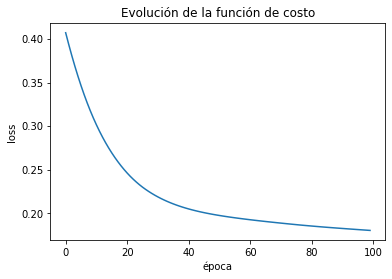

2) Test RMSE: 129.124


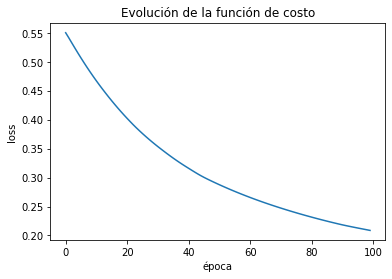

3) Test RMSE: 114.239


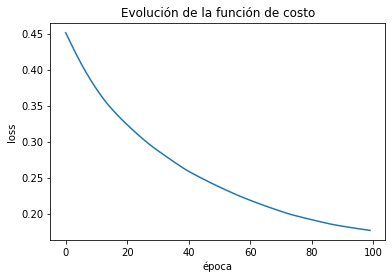

4) Test RMSE: 105.875


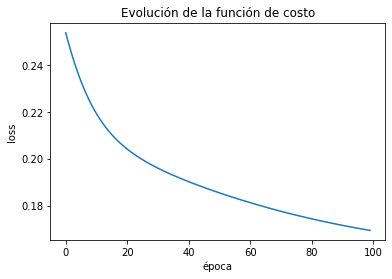

5) Test RMSE: 111.183


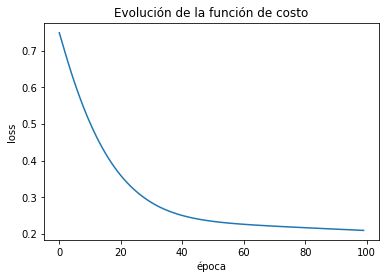


Fitting model using MLP with 4 neurons
1) Test RMSE: 97.088


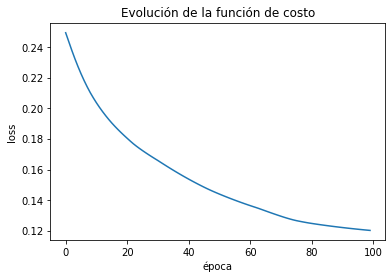

2) Test RMSE: 126.291


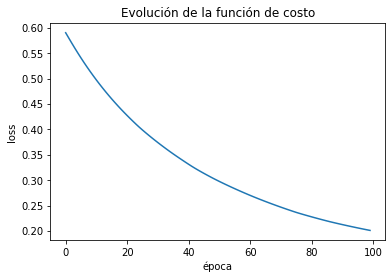

3) Test RMSE: 109.425


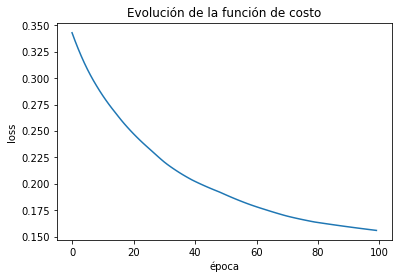

4) Test RMSE: 98.975


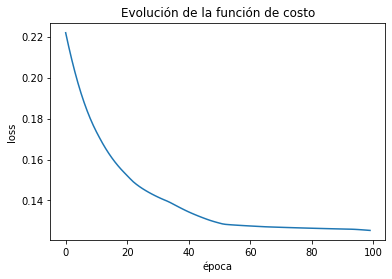

5) Test RMSE: 89.788


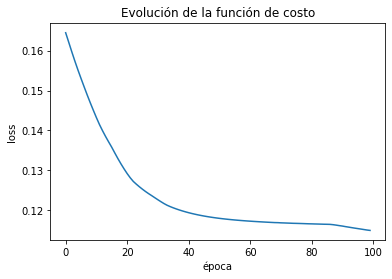


Fitting model using MLP with 5 neurons
1) Test RMSE: 105.660


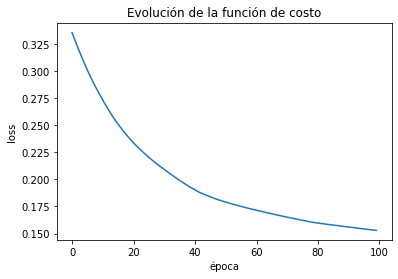

2) Test RMSE: 126.476


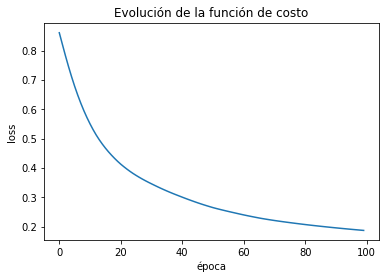

3) Test RMSE: 95.917


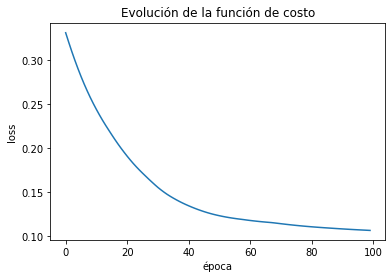

4) Test RMSE: 90.203


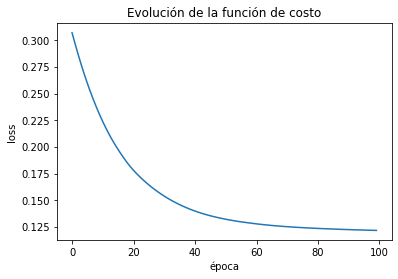

5) Test RMSE: 93.702


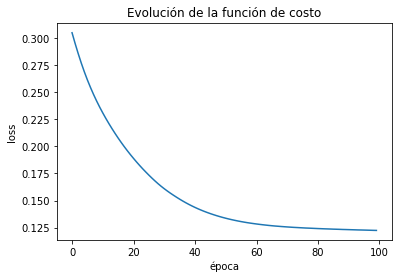

                1           2           3           4           5
count    5.000000    5.000000    5.000000    5.000000    5.000000
mean   133.805374  108.109621  113.370358  104.313090  102.391601
std     15.852639   20.883209    9.461257   14.149482   14.634917
min    106.378228   91.817451  105.874510   89.787770   90.202749
25%    135.312255   94.022823  106.430809   97.087914   93.702387
50%    138.830681  103.695926  111.183371   98.974518   95.917069
75%    142.361787  107.397728  114.239044  109.424530  105.659955
max    146.143921  143.614178  129.124054  126.290718  126.475846


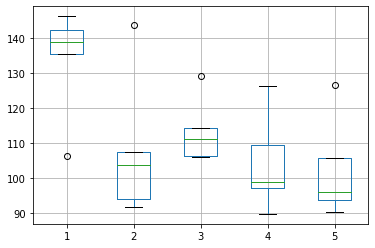

In [12]:
# experiment
repeats = 5
results = pd.DataFrame()
lag = 1
epochs=100

# vary training epochs

neurons = [1, 2, 3, 4, 5]
for n in neurons:
    print("\nFitting model using MLP with {} neurons".format(n))
    results[str(n)] = experiment(repeats, series, epochs, lag, n)
    
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
plt.savefig('figures/boxplot_neurons.png')

## Analisis avanzando

In [13]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 2
    n_epochs = 200
    n_neurons = 3
    n_lag = 3
    
    # load dataset
    series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        plt.plot(history['train'], color='blue', label=('Train' if i==0 else None) )
        plt.plot(history['test'], color='orange', label=('Test' if i==0 else None) )
        plt.legend()
        
        plt.title('Evolución de la función de costo')
        plt.ylabel('RMSE')
        plt.xlabel('época')

        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))

    plt.savefig('figures/diagnostic_neurons_lag.png')

In [ ]:
run()

In [ ]:
# run diagnostic experiments
def run():
    # config
    repeats = 10
    n_batch = 4
    n_epochs = 200
    n_neurons = 3
    n_lag = 3
    
    # load dataset
    series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    
    # run diagnostic tests
    for i in range(repeats):
        history = fit(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        plt.plot(history['train'], color='blue', label=('Train' if i==0 else None) )
        plt.plot(history['test'], color='orange', label=('Test' if i==0 else None) )
        plt.legend()
        
        plt.title('Evolución de la función de costo')
        plt.ylabel('RMSE')
        plt.xlabel('época')

        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))

    plt.savefig('figures/diagnostic_neurons_lag_batch4.png')

run()